In [1]:
import torch as tc
tc.set_default_dtype(tc.float64)

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import dCl
from joblib import Parallel, delayed
import time

%load_ext autoreload
%autoreload 1
%aimport dCl

In [3]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 18,
})

In [4]:
Nz = 8
zmin = 0.3
zmax = 1.0
zmin_text = '{:.2f}'.format(zmin)
zmax_text = '{:.2f}'.format(zmax)
zlist = tc.linspace(zmin, zmax, Nz)

l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
pz_list = 10.**tc.linspace(-3,-1, 16)

params = []
for l in l_list:
    for pz in pz_list:
        params.append([l, pz])


dCl_obj = dCl.Cl_kSZ2_HI2(zlist)
Beam_HI = tc.empty([len(zlist), len(l_list)])
for zi in range(len(zlist)):
    Beam_HI[zi] = dCl_obj.Beam_HI(l_list, zindex=zi)

print('redshift from ' + zmin_text + ' to ' + zmax_text)
# params = tc.tensor(params).reshape([len(l_list)*len(pz_list), 2])

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


redshift from 0.30 to 1.00


### 1. Read in the data

#### Test on Term 5 and 6 Cross-correlation

In [6]:
Nz = 2
zlist = tc.linspace(0.4, 0.5, Nz)
l_list = tc.linspace(50, 200, 10)
pz_list = 10.**tc.linspace(-3,-1, 16)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor (2pi)^(-5) for volume element from integral over l1 l2 pz
data_total = tc.tensor(np.load('Data/Term5and6.npy')) * 2 * 2 / (2*tc.pi)**5

print(len(zlist), len(l_list), len(pz_list), len(l1_list), data_total.shape[-1])
print(data_total.shape)

2 10 16 90 2
torch.Size([2, 10, 16, 90, 2])


In [7]:
########################################################################
# Sum over term 5 and 6, and then integrate over l1
data_term5 = tc.trapz(data_total[..., 0], l1_list, dim=-1)
data_term6 = tc.trapz(data_total[..., 1], l1_list, dim=-1)
data_int_l1 = tc.trapz(data_total.sum(dim=-1), l1_list, dim=-1)

########################################################################
# Integrate over pz
data_int_pz = tc.trapz(data_int_l1, pz_list, dim=-1)

########################################################################
# Integrate over chi
dCl_obj = dCl.Cl_kSZ2_HI2(np.array([0.4, 0.5]))
Cl_cross = tc.trapz(data_int_pz.T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI , dCl_obj.chi_of_z, dim=-1)

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


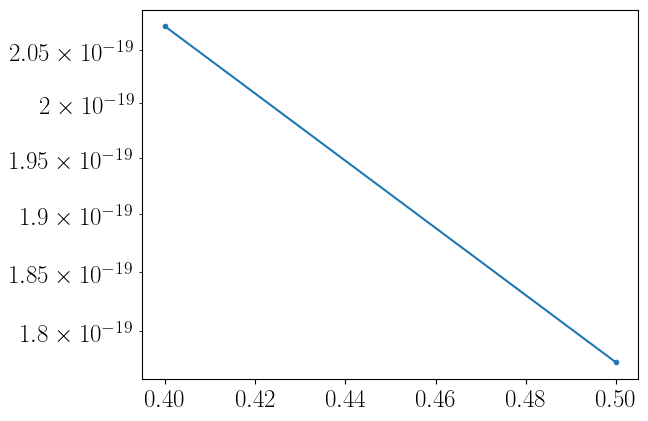

In [8]:
plt.plot(dCl_obj.z_list, (data_int_pz.T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI)[0], '.-')
plt.yscale('log')
plt.show()

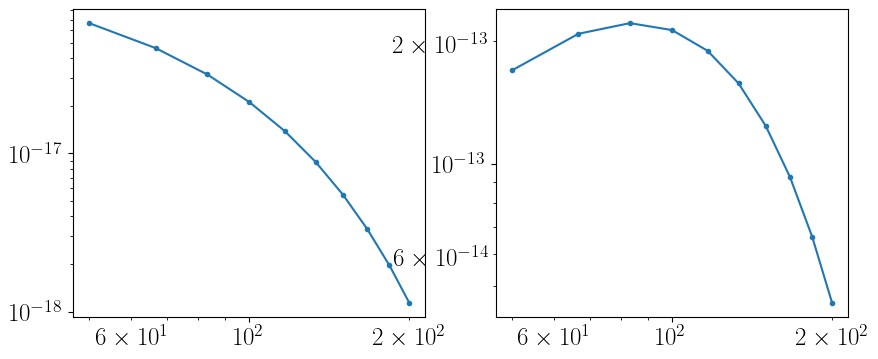

In [9]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.show()

#### Cross-correlation

In [5]:
Nz = 8
zmin = 0.3
zmax = 1.0
zlist = tc.linspace(zmin, zmax, Nz)
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
pz_list = 10.**tc.linspace(-3,-1, 16)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                    10.**tc.linspace(0, 1, 6)[:-1], 
                    tc.linspace(10, 300, 59)[:-1], 
                    10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                    10.**tc.linspace(3, 4, 10)])

# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor (2pi)^(-5) for volume element from integral over l1 l2 pz
# data_total = tc.tensor(np.load('Data/Term5and6.npy')) * 2 * 2 / (2*tc.pi)**5

data_total = np.load(f'./Beam_data/z_0.30_1.00/dCl_cross.npy') # in unit K^2
data_total = tc.tensor(data_total) * 2 * 2 / (2*tc.pi)**5


print(len(zlist), len(l_list), len(pz_list), len(l1_list), data_total.shape[-1])
print(data_total.shape)

8 29 16 90 90
torch.Size([8, 29, 16, 90])


In [6]:
########################################################################
# Integrate over l1
data_int_l1 = tc.trapz(2 * data_total, l1_list, dim=-1)

########################################################################
# Integrate over pz
data_int_pz = tc.trapz(data_int_l1, pz_list, dim=-1)

########################################################################
# Integrate over chi
# One more beam factor from HI
Cl_cross = tc.trapz((data_int_pz * Beam_HI**2 / Beam_HI[0]).T   * dCl_obj.F_kSZ**2 * dCl_obj.G_HI, 
                    dCl_obj.chi_of_z, dim=-1)

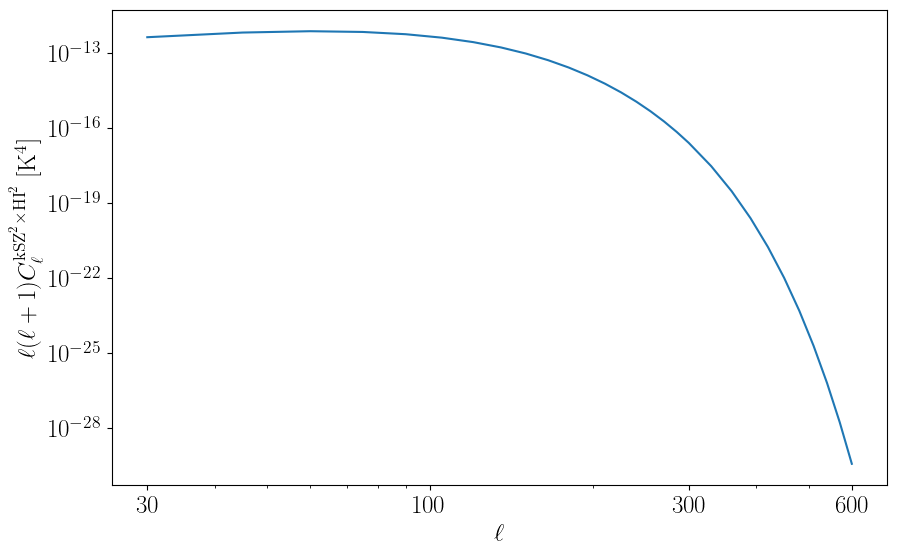

In [7]:
fig = plt.figure(figsize=(10, 6.18), dpi=100)
# times (2.7K)^2 to convert to temperature unit

plt.plot(l_list, l_list * (l_list + 1) * Cl_cross * (2.7)**2, '-')
plt.xscale('log')
plt.yscale('log')

plt.xticks([30, 100, 300, 600], ['30', '100', '300', '600'])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2}$ [$\mathrm{K}^4$]', usetex=True)

plt.savefig('cross_correlation.pdf', bbox_inches = 'tight')
plt.show()

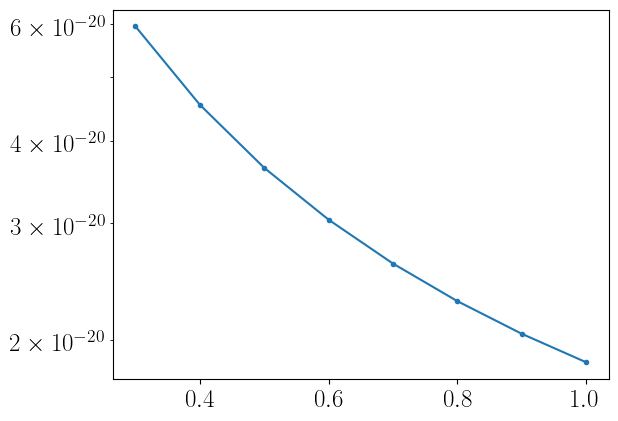

In [30]:
plt.plot(dCl_obj.z_list, ((data_int_pz*Beam_HI).T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI)[0], '.-')
plt.yscale('log')
plt.show()

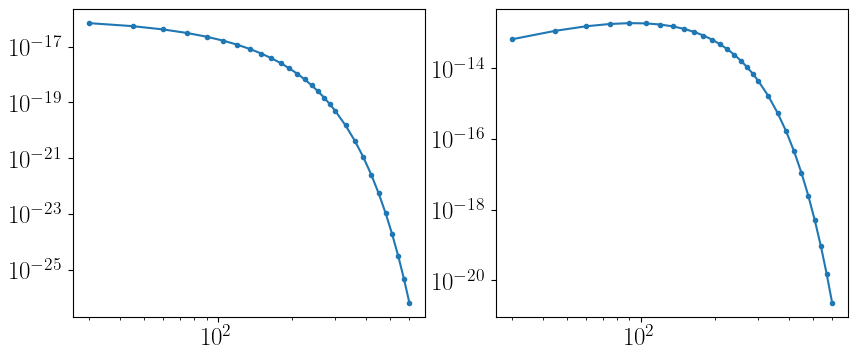

In [23]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.show()

#### HI square field auto-correlation

In [41]:
Nz = 8
zmin = 0.3
zmax = 1.0
zlist = tc.linspace(zmin, zmax, Nz)
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])

dCl_HI2 = tc.tensor(np.load('Beam_data/z_0.30_1.00/dCl_HI2.npy'))
dCl_HI2_nobeam = tc.tensor(np.load('Beam_data/z_0.30_1.00/dCl_HI2_nobeam.npy'))
dCl_HI2_nonoise = tc.tensor(np.load('Beam_data/z_0.30_1.00/dCl_HI2_nonoise.npy'))
dCl_HI2_nobeam_nonoise = tc.tensor(np.load('Beam_data/z_0.30_1.00/dCl_HI2_nobeam_nonoise.npy'))


# Integrate over chi
Cl_HI2 = tc.trapz((dCl_HI2).T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)
Cl_HI2_nobeam = tc.trapz(dCl_HI2_nobeam.T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)

Cl_HI2_nonoise = tc.trapz((dCl_HI2_nonoise).T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)
Cl_HI2_nobeam_nonoise = tc.trapz(dCl_HI2_nobeam_nonoise.T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)

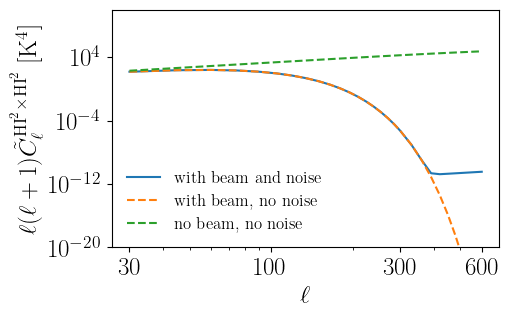

In [43]:
fig = plt.figure(figsize=(5, 3.09), dpi=100)

# times (2.7K)^2 to convert to temperature unit
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2, '-', label='with beam and noise')
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2_nonoise, '--', label='with beam, no noise')
# plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2_nobeam * dCl_obj.Beam_HI(l_list, zindex=0, use_mean=True), '-', label='no beam, with noise')
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2_nobeam_nonoise, '--', label='no beam, no noise')
plt.legend(fontsize=12, frameon=False)
plt.xscale('log')
plt.yscale('log')

plt.xticks([30, 100, 300, 600], ['30', '100', '300', '600'])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylim([1e-20, 1e10])
plt.ylabel(r'$\ell(\ell+1)\tilde{C}_{\ell}^{{\rm HI}^2 \times {\rm HI}^2}$ [$\mathrm{K}^4$]', usetex=True)

plt.savefig('Figs/Cl_HI2.pdf', bbox_inches = 'tight')
plt.show()

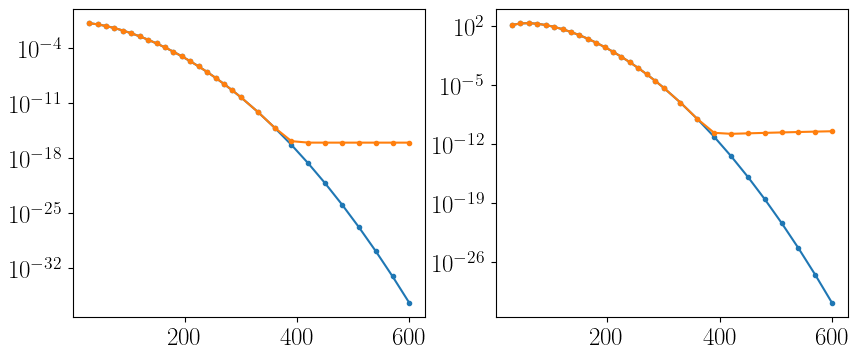

In [80]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_HI2_nonoise, '.-')
plt.plot(l_list, Cl_HI2, '.-')
# plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2_nonoise, '.-')
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2, '.-')
# plt.xscale('log')
plt.yscale('log')

plt.show()

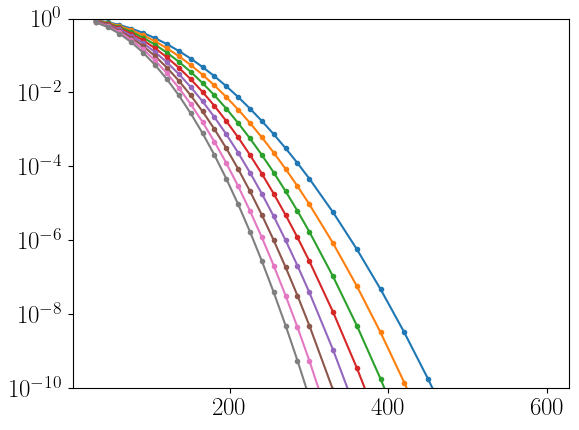

In [98]:
for zi in range(len(zlist)):
    plt.plot(l_list, dCl_obj.Beam_HI(l_list, zindex=zi)**2, '.-')
# plt.xscale('log')
plt.ylim([1e-10, 1])
plt.yscale('log')

plt.show()

#### kSZ square field auto-correlation

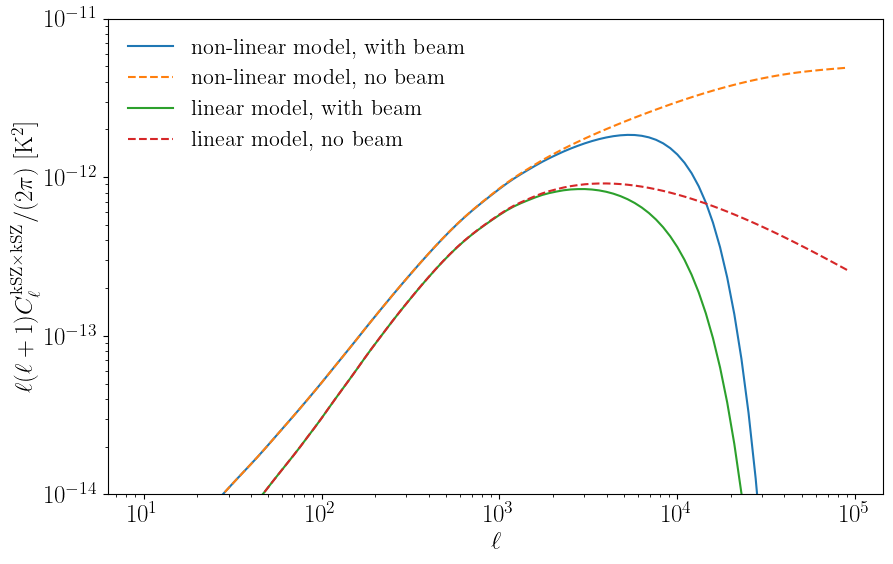

In [54]:
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))

# times (2.7K)^2 to convert to temperature unit
Cl_kSZ = tc.tensor(np.load('Data/Cl_kSZ.npy')) * (2.7)**2 / (2*np.pi)
Cl_kSZ_nobeam = Cl_kSZ / dCl_obj.Beam_kSZ(l_list_kSZ)

Cl_kSZ_linear = tc.tensor(np.load('Data/Cl_kSZ_linear.npy'))* (2.7)**2 / (2*np.pi)
Cl_kSZ_nobeam_linear = Cl_kSZ_linear / dCl_obj.Beam_kSZ(l_list_kSZ)


fig = plt.figure(figsize=(10, 6.18), dpi=100)

xi, xe = 0, -1
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ)[xi:xe], '-', label='non-linear model, with beam')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam)[xi:xe], '--', label='non-linear model, no beam')

plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_linear)[xi:xe], '-', label='linear model, with beam')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam_linear)[xi:xe], '--', label='linear model, no beam')

plt.legend(fontsize=16, frameon=False)

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-11])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}} / (2\pi)$ [$\mathrm{K}^2$]', usetex=True)

plt.savefig('Cl_kSZ.pdf', bbox_inches = 'tight')
plt.show()

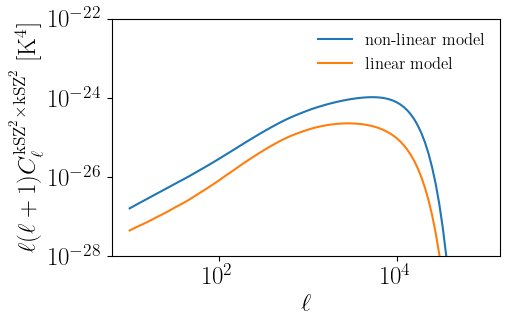

In [55]:
# The factor (2pi)^(-2) for volume element from convolution over l'
CL_kSZ2 = tc.tensor(np.load('Data/CL_kSZ2.npy')) / (2*tc.pi)**2
CL_kSZ2_linear = tc.tensor(np.load('Data/CL_kSZ2_linear.npy')) / (2*tc.pi)**2

fig = plt.figure(figsize=(5, 3.09), dpi=100)
xi, xe = 0, -1
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * CL_kSZ2)[xi:xe], '-', label='non-linear model')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * CL_kSZ2_linear)[xi:xe], '-', label='linear model')
plt.legend(fontsize=12, frameon=False)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$ [$\mathrm{K}^4$]', usetex=True)
plt.ylim([1e-28, 1e-22])

plt.savefig('Cl_kSZ2.pdf', bbox_inches = 'tight')
plt.show()

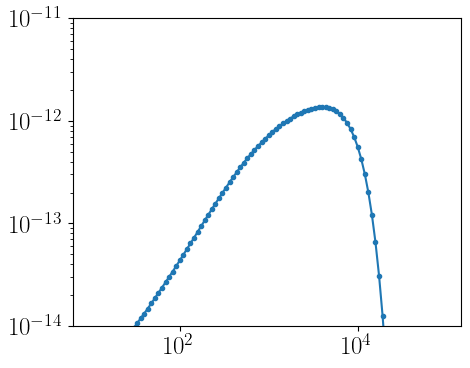

In [20]:
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))

Cl_kSZ = tc.tensor(np.load('Data/Cl_kSZ.npy'))

fig = plt.figure(figsize=(5,4))
xi, xe = 0, -1
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ)[xi:xe], '.-')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-11])
plt.show()

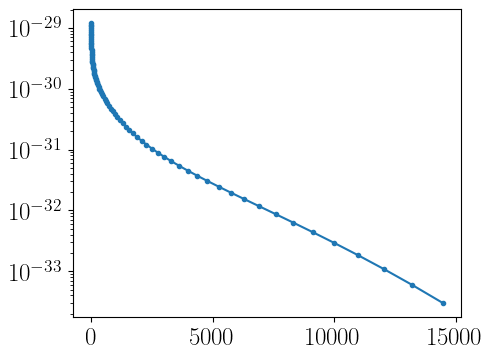

In [21]:
# The factor (2pi)^(-2) for volume element from convolution over l'
CL_kSZ2 = tc.tensor(np.load('Data/CL_kSZ2.npy')) / (2*tc.pi)**2

fig = plt.figure(figsize=(5,4))
xi, xe = 0, 80
plt.plot(l_list_kSZ[xi:xe], CL_kSZ2[xi:xe], '.-')
plt.yscale('log')
plt.show()

### 2. SNR Estimation

#### SNR of l  and  SNR_total

In [44]:
def get_Cl_cross(dCl_cross, dCl_obj, pz_list, l1_list):
    ########################################################################
    # Integrate over l1
    data_int_l1 = tc.trapz(2 * dCl_cross, l1_list, dim=-1)

    ########################################################################
    # Integrate over pz
    data_int_pz = tc.trapz(data_int_l1, pz_list, dim=-1)

    ########################################################################
    # Integrate over chi
    # One more beam factor from HI
    Cl_cross = tc.trapz((data_int_pz * Beam_HI**2 / Beam_HI[0]).T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI , dCl_obj.chi_of_z, dim=-1)
    # Cl_cross = tc.trapz((data_int_pz).T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI , dCl_obj.chi_of_z, dim=-1)

    return Cl_cross


def torch_interp1d(x, y, x_new):

    indices = tc.searchsorted(x, x_new) - 1
    indices = tc.clamp(indices, 0, len(x) - 2)

    x0, x1 = x[indices], x[indices + 1]
    y0, y1 = y[indices], y[indices + 1]

    slope = (y1 - y0) / (x1 - x0)
    y_query = y0 + slope * (x_new - x0)
    
    return y_query

def loglog_torch_itp(x, y, x_new):
    return 10**torch_interp1d(tc.log10(x), tc.log10(y), tc.log10(x_new))

In [45]:
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                    10.**tc.linspace(0, 1, 6)[:-1], 
                    tc.linspace(10, 300, 59)[:-1], 
                    10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                    10.**tc.linspace(3, 4, 10)])

''' 1. Get Cl_cross'''
# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor (2pi)^(-5) for volume element from integral over l1 l2 pz

# data_total = []
# for i in range(8):
#     data_i = np.load(f'./Beam_data/z_0.30_1.00/Cl_cross_{i}.npy') / 1e6  # convert to K^2
#     data_total.append(data_i)

data_total = np.load(f'./Beam_data/z_0.30_1.00/dCl_cross.npy') #np.array(data_total)
data_total = tc.tensor(data_total) * 2 * 2 / (2*tc.pi)**5
Cl_cross = get_Cl_cross(data_total, dCl_obj, pz_list, l1_list)

''' 2. Get Cl_HI square'''
dCl_HI2 = tc.tensor(np.load('Beam_data/z_0.30_1.00/dCl_HI2.npy'))
dCl_HI2_nonoise = tc.tensor(np.load('Beam_data/z_0.30_1.00/dCl_HI2_nonoise.npy'))
# Cl_HI2 = tc.trapz((dCl_HI2).T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)
Cl_HI2 = tc.trapz((dCl_HI2).T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)
Cl_HI2_nonoise = tc.trapz((dCl_HI2_nonoise).T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)

''' 3. Get Cl_kSZ square'''
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
CL_kSZ2 = tc.tensor(np.load('Data/CL_kSZ2.npy')) / (2*tc.pi)**2


''' 4. Evaluate SNR square'''
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
l30_600 = tc.arange(30, 600)


In [46]:
def loglog_itp_n(x, y, x_new, order=2):
    return 10**(interp1d(tc.log10(x), tc.log10(y), kind=order)(tc.log10(x_new)))

Cl_kSZ2_HI2 = loglog_itp_n(l_list, Cl_cross, l_list)
Cl_HI2_auto = loglog_itp_n(l_list, Cl_HI2, l_list)
Cl_HI2_nonoise_auto = loglog_itp_n(l_list, Cl_HI2_nonoise, l_list)
Cl_kSZ2_auto = loglog_itp_n(l_list_kSZ, CL_kSZ2, l_list)

In [47]:
fsky = 8000. / 40000.
SNR_coarse = fsky * (2 * l_list + 1) * Cl_kSZ2_HI2**2 / (Cl_kSZ2_HI2**2 + Cl_HI2_auto * Cl_kSZ2_auto)
SNR_coarse_nonoise = fsky * (2 * l_list + 1) * Cl_kSZ2_HI2**2 / (Cl_kSZ2_HI2**2 + Cl_HI2_nonoise_auto * Cl_kSZ2_auto)

l30_600 = tc.arange(30, 600)
SNR = tc.tensor(loglog_itp_n(l_list, SNR_coarse, l30_600))
SNR_nonoise = tc.tensor(loglog_itp_n(l_list, SNR_coarse_nonoise, l30_600))
# l30_330 = tc.arange(30, 330)
# l330_600 = tc.arange(330, 600)
# SNR1 = tc.tensor(loglog_itp_n(l_list[:20], SNR_coarse[:20], l30_330))
# SNR2 = tc.tensor(loglog_itp_n(l_list[19:], SNR_coarse[19:], l330_600))
# SNR = tc.hstack([SNR1, SNR2])
# SNR = tc.tensor(loglog_itp_n(l_list, SNR_coarse, l30_600))

SNR_cs = tc.cumsum(SNR, dim=0)
SNR_nonoise_cs = tc.cumsum(SNR_nonoise, dim=0)

SNR.shape, SNR_cs.shape

(torch.Size([570]), torch.Size([570]))

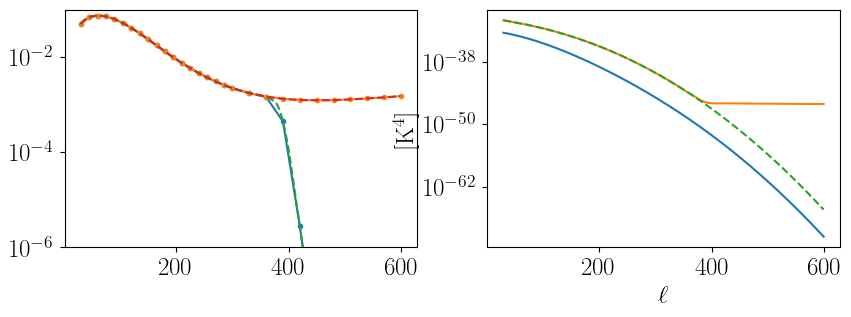

In [48]:
Cl_kSZ2_HI2 = loglog_itp_n(l_list, Cl_cross, l30_600)
Cl_HI2_auto = loglog_itp_n(l_list, Cl_HI2, l30_600)
Cl_HI2_nonoise_auto = loglog_itp_n(l_list, Cl_HI2_nonoise, l30_600)
Cl_kSZ2_auto = loglog_itp_n(l_list_kSZ, CL_kSZ2, l30_600)

fig = plt.figure(figsize=(10, 3.09))

plt.subplot(1,2,1)
plt.plot(l_list, SNR_coarse, '.-')
plt.plot(l_list, SNR_coarse_nonoise, '.-')
plt.plot(l30_600, SNR, '--')
plt.plot(l30_600, SNR_nonoise, '--')
# plt.plot(l30_330, SNR1)
# plt.plot(l330_600, SNR2)
plt.yscale('log')

# plt.xlim([20,400])
plt.ylim([1e-6,1e-1])

plt.subplot(1,2,2)
plt.plot(l30_600, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_600, Cl_HI2_auto * Cl_kSZ2_auto, label = r'$\tilde{C}_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} \tilde{C}_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
plt.plot(l30_600, Cl_HI2_nonoise_auto * Cl_kSZ2_auto, '--',
        label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
# plt.legend()
# plt.xscale('log')
plt.yscale('log')
# plt.ylim([1e-60, 1e-29])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'[$\mathrm{K}^4$]', usetex=True)

# plt.plot(l_list, dCl_obj.Beam_HI(l_list, zindex=0, use_mean=True)**2, '.-')
# plt.yscale('log')

plt.show()

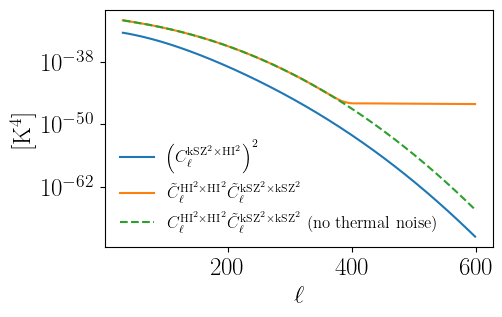

In [49]:
Cl_kSZ2_HI2 = loglog_itp_n(l_list, Cl_cross, l30_600)
Cl_HI2_auto = loglog_itp_n(l_list, Cl_HI2, l30_600)
Cl_HI2_nonoise_auto = loglog_itp_n(l_list, Cl_HI2_nonoise, l30_600)
Cl_kSZ2_auto = loglog_itp_n(l_list_kSZ, CL_kSZ2, l30_600)

fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(l30_600, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_600, Cl_HI2_auto * Cl_kSZ2_auto, 
        label = r'$\tilde{C}_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} \tilde{C}_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
plt.plot(l30_600, Cl_HI2_nonoise_auto * Cl_kSZ2_auto, '--', 
        label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} \tilde{C}_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$ (no thermal noise)')

plt.legend(fontsize=12, frameon=False)
# plt.xscale('log')
plt.yscale('log')
# plt.ylim([1e-40, 1e-30])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'[$\mathrm{K}^4$]', usetex=True)

plt.savefig('Figs/comparison.pdf', bbox_inches = 'tight')
plt.show()

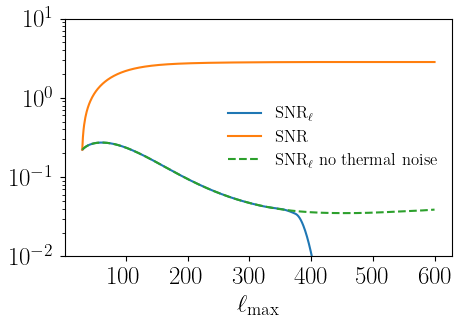

In [51]:
fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(l30_600, np.sqrt(SNR), label = r'$\mathrm{SNR}_{\ell}$')
plt.plot(l30_600, np.sqrt(SNR_cs), label = r'$\mathrm{SNR}$')
plt.plot(l30_600, np.sqrt(SNR_nonoise), '--', label = r'$\mathrm{SNR}_{\ell}$ no thermal noise')
# plt.plot(l30_600, np.sqrt(SNR_nonoise_cs), '--', label = r'$\mathrm{SNR}$ no noise')
plt.legend(fontsize=12, frameon=False)
# plt.xscale('log')
plt.yscale('log')
# plt.yticks([0.3,1,3,6], [0.3,1.0,3.0,6.0])
plt.ylim([1e-2, 10])
plt.xticks([100, 200, 300, 400, 500, 600], [100, 200, 300, 400, 500, 600])

plt.xlabel(r'$\ell_{\mathrm{max}}$', usetex=True)

plt.savefig('Figs/SNR.pdf', bbox_inches = 'tight')
plt.show()

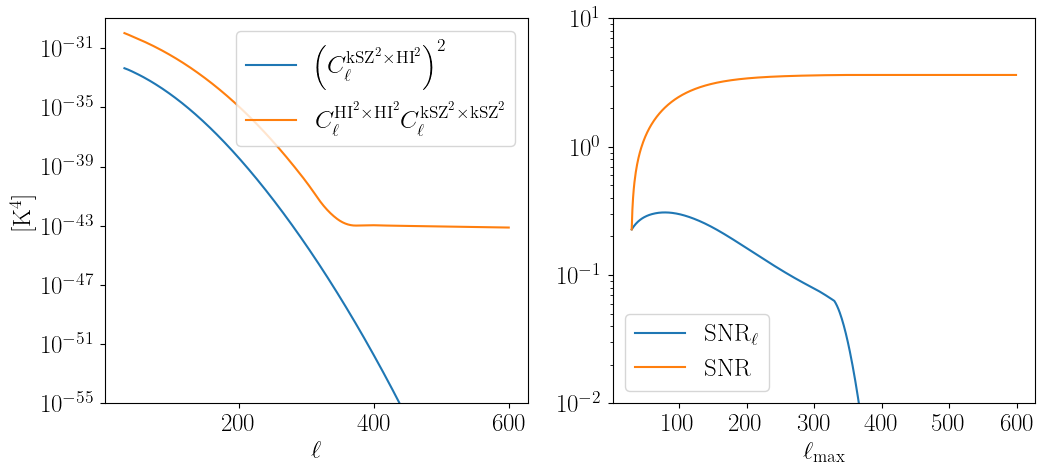

In [79]:
# With all beams
fig = plt.figure(figsize=(12,5))

####################################################################
plt.subplot(1,2,1)
plt.plot(l30_600, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_600, Cl_HI2_auto * Cl_kSZ2_auto, label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-55, 1e-29])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'[$\mathrm{K}^4$]', usetex=True)

####################################################################
plt.subplot(1,2,2)
plt.plot(l30_600, np.sqrt(SNR), label = r'$\mathrm{SNR}_{\ell}$')
plt.plot(l30_600, np.sqrt(SNR_cs), label = r'$\mathrm{SNR}$')
plt.legend()
plt.yscale('log')
# plt.yticks([0.3,1,3,6], [0.3,1.0,3.0,6.0])
plt.ylim([1e-2, 10])
plt.xticks([100, 200, 300, 400, 500, 600], [100, 200, 300, 400, 500, 600])
plt.xlabel(r'$\ell_{\mathrm{max}}$', usetex=True)

####################################################################
# plt.savefig('Figs/SNR2.pdf', bbox_inches = 'tight')
plt.show()

#### Turning point

In [17]:
Tsys = 22           # K
deltaNu = 2e5       # Hz
Ddish = 13.5        # m
wavelength = 0.21   # m
theta_b = 1.02 * wavelength / Ddish * 180/np.pi # deg
As = 8000           # deg^2

Ntot = 64
Tobs = 1e3 * 3600   # s
Skycover = 20000    # deg^2
Ttot = Ntot * (As / Skycover) * Tobs # seconds

thermal_noise = Tsys**2 / (deltaNu * Ttot) * (4/np.pi)**2 * (As/theta_b**2)
print(r'$\sigma_\mathrm{T}^2$ at $z=0$ :', thermal_noise, r'$\mathrm{K}^2$')


zz = dCl_obj.z_array - (1+dCl_obj.z_array)**2 * 0.2 / 1420.
dz = dCl_obj.chi_of_z - tc.tensor(dCl_obj.results.comoving_radial_distance(zz))
volume = (theta_b * np.pi / 180. * dCl_obj.chi_of_z)**2 * dz
print(r'The volume of pixel at different redshifts are ', volume, 'Mpc^3')

$\sigma_\mathrm{T}^2$ at $z=0$ : 4.1206569773879047e-07 $\mathrm{K}^2$
The volume of pixel at different redshifts are  tensor([ 343.1347,  632.5214, 1012.0041, 1477.1676, 2021.4597, 2637.2380,
        3316.5296, 4051.5351]) Mpc^3


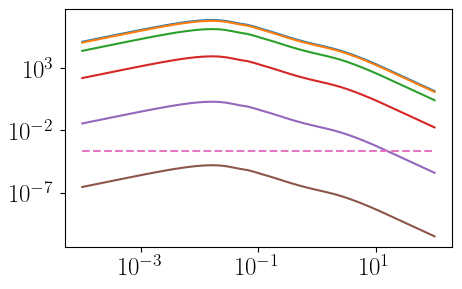

In [18]:
zindex = 3
chi_i = dCl_obj.chi_of_z[zindex]
kklist = 10**tc.linspace(-4,2,50)  # in unit Mpc^{-1}
Pklist = dCl_obj.Power_matter_1d(kklist, zindex) * dCl_obj.Tb_of_z[zindex]**2
Pnoise = thermal_noise * volume[zindex] / (1 + dCl_obj.z_list[zindex])**2


fig = plt.figure(figsize=(5, 3.09))

plt.loglog(kklist, Pklist)
for l in [30, 100, 200, 300, 400]:
    plt.loglog(kklist, Pklist * dCl_obj.Beam_HI(l, zindex)**2)
# plt.loglog(kklist, Pklist * dCl_obj.Beam_HI(400, zindex)**2)

plt.loglog(kklist, tc.ones_like(kklist) * Pnoise, '--')

plt.show()

### 3. Other Plots

#### Cross-correlation

In [57]:
data6 = np.load('./testdata/Beam_data/z_0.30_1.00/Cl_cross_6.npy')
data7 = np.load('./testdata/Beam_data/z_0.30_1.00/Cl_cross_7.npy')
data_total = tc.tensor(np.array([data6, data7])) * 2 * 2 / (2*tc.pi)**5

l_list = tc.linspace(30, 300, 19)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

data_total.shape

torch.Size([2, 19, 16, 90])

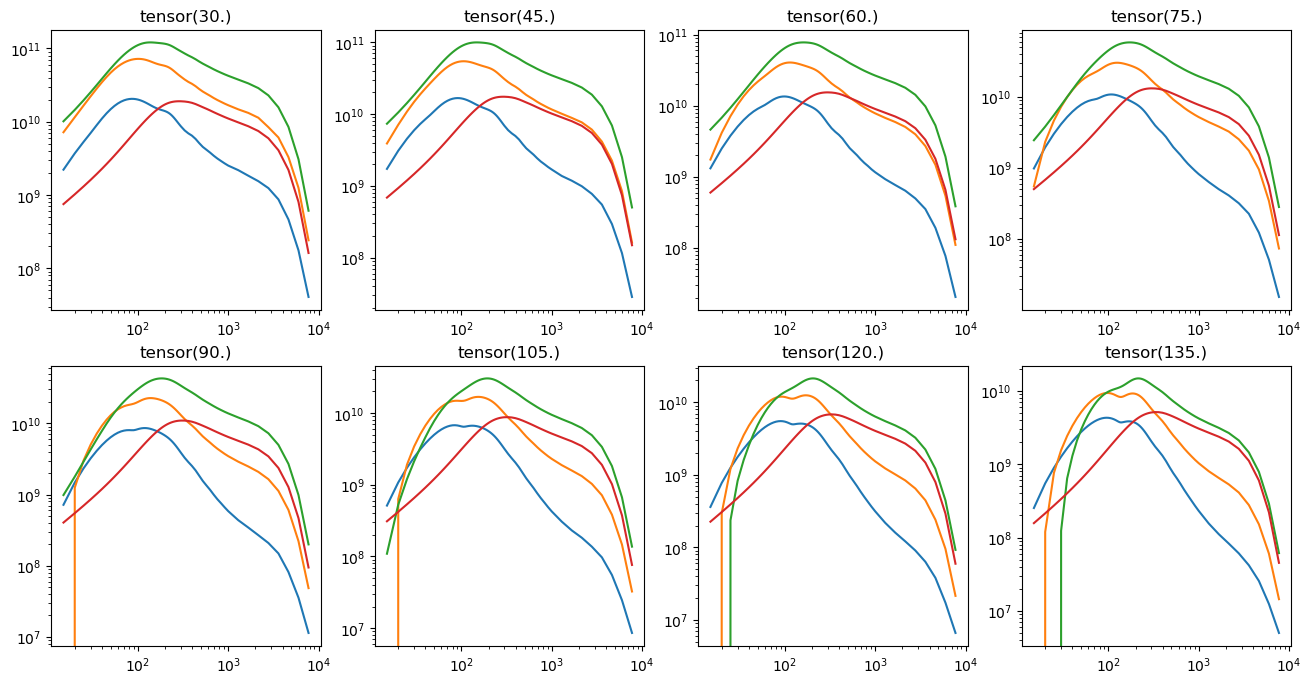

In [58]:
data_beam = data_total[0]

lindex = 3 # l=100
pz_index = 0 # pz=0.01
temr_index = 0
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))

xi, xe = 10, -1

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(l1_list[xi:xe], data_beam[i, ::4, xi:xe].T)
    # plt.plot(l1_list[xi:xe], data_beam[i, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(l1_list[xi:xe], data_beam[i+4, ::4, xi:xe].T)
    # plt.plot(l1_list[xi:xe], data_beam[i+4, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i+4]))

plt.show()

In [59]:
data_term_both = tc.trapz(data_total, l1_list, dim=-1)

data_term_both.shape

torch.Size([2, 19, 16])

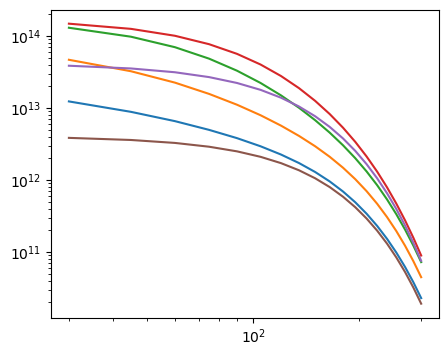

In [61]:
zindex = 0
pz_index = 1
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(5,4))

plt.plot(l_list, data_term_both[zindex, :, ::3])
plt.xscale(xscale)
plt.yscale(yscale)

plt.show()


In [62]:
pz_list.shape, data_term_both.shape

(torch.Size([16]), torch.Size([2, 19, 16]))

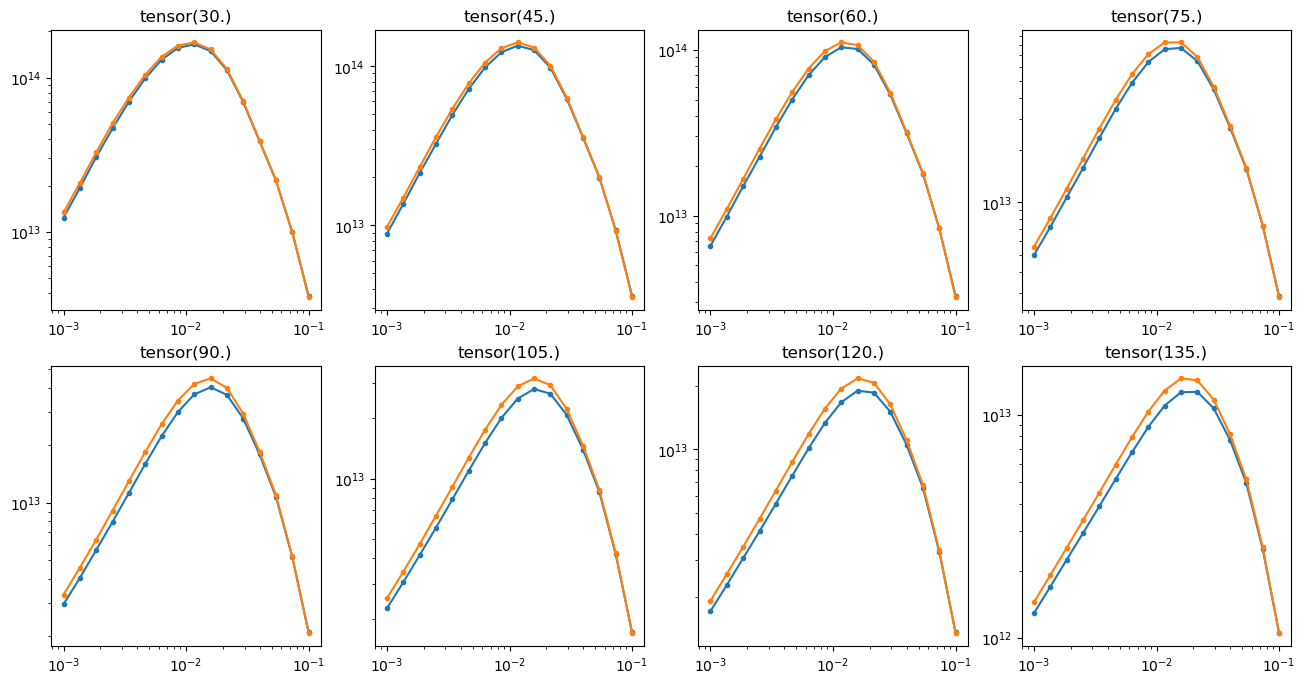

In [63]:
lindex = 0 # l=50
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))


for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(pz_list, data_term_both[:, i].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(pz_list, data_term_both[:, i+5].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i+4]))

plt.show()

#### Test on Term 5 and 6 Cross-correlation

In [33]:
data_total = tc.tensor(np.load('Data/Term5and6.npy')) * 2 * 2 / (2*tc.pi)**5

l_list = tc.linspace(50, 200, 10)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

data_total.shape

torch.Size([2, 10, 16, 90, 2])

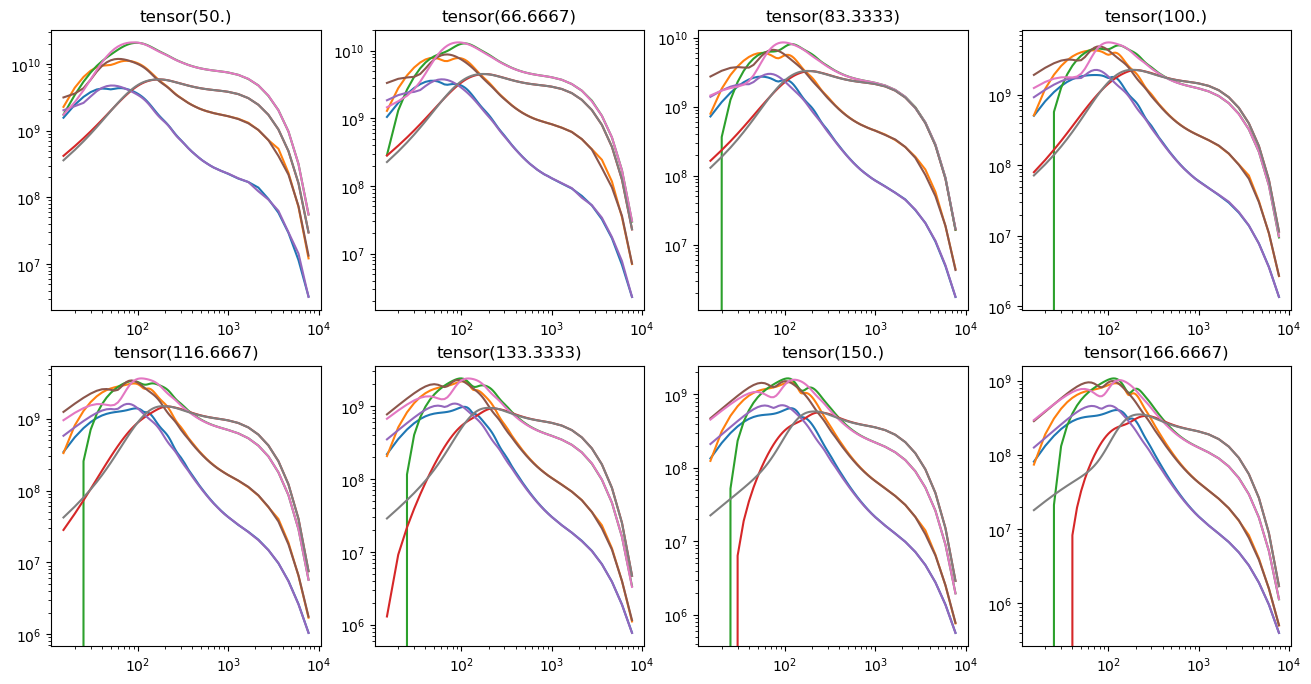

In [34]:
data_beam = data_total[0]

lindex = 3 # l=100
pz_index = 0 # pz=0.01
temr_index = 0
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))

xi, xe = 10, -1

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(l1_list[xi:xe], data_beam[i, ::4, xi:xe, 0].T)
    plt.plot(l1_list[xi:xe], data_beam[i, ::4, xi:xe, 1].T)
    # plt.plot(l1_list[xi:xe], data_beam[i, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(l1_list[xi:xe], data_beam[i+4, ::4, xi:xe,0].T)
    plt.plot(l1_list[xi:xe], data_beam[i+4, ::4, xi:xe, 1].T)
    # plt.plot(l1_list[xi:xe], data_beam[i+4, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i+4]))

plt.show()

In [37]:
data_term5 = tc.trapz(data_total[..., 0], l1_list, dim=-1)
data_term6 = tc.trapz(data_total[..., 1], l1_list, dim=-1)
data_term_both = tc.trapz(data_total.sum(dim=-1), l1_list, dim=-1)

data_term5.shape, data_term_both.shape

(torch.Size([2, 10, 16]), torch.Size([2, 10, 16]))

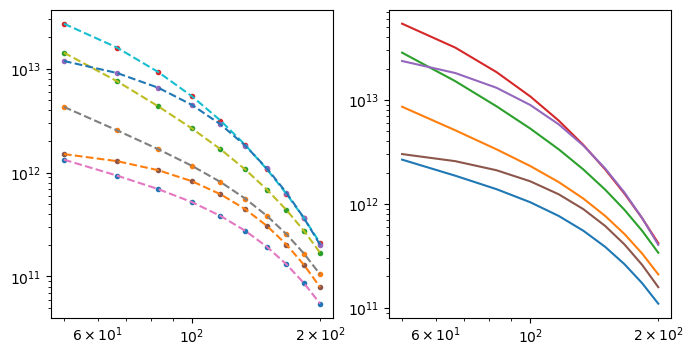

In [38]:
zindex = 0 # z=0.4
pz_index = 1 # pz=0.01
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(l_list, data_term5[zindex,:, ::3], '.')
plt.plot(l_list, data_term6[zindex,:, ::3], '--')
plt.xscale(xscale)
plt.yscale(yscale)

plt.subplot(1,2,2)
plt.plot(l_list, data_term_both[zindex,:, ::3])
plt.xscale(xscale)
plt.yscale(yscale)

plt.show()


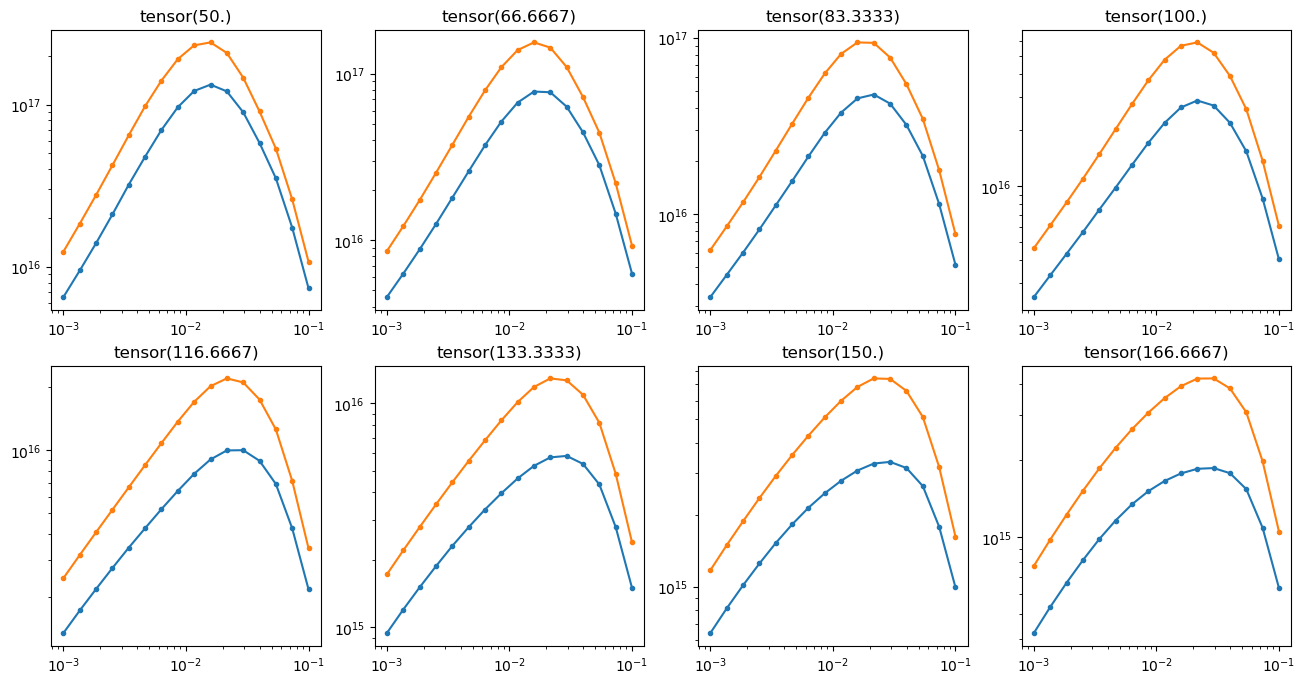

In [24]:
lindex = 0 # l=50
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))


for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(pz_list, data_term_both[:, i].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(pz_list, data_term_both[:, i+5].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i+4]))

plt.show()